In [34]:
import os
import scanpy as sc

home = '/home/kojo/Code/trVAE_reproducibility-2'
os.chdir(home)

In [35]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
import seaborn as sb
import reptrvae

In [36]:
adata = sc.read('./data/alzPro_count.h5ad')
adata

AnnData object with n_obs × n_vars = 48 × 1729
    obs: 'Qi ID', 'sex', 'Group', 'Timepoint'
    var: 'index'

In [37]:
adata.obs['Group'].value_counts()

HET    24
WT     24
Name: Group, dtype: int64

In [38]:
sc.pp.normalize_per_cell(adata)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=500)

In [252]:
adata = adata[:, adata.var['highly_variable']]

In [39]:
adata

AnnData object with n_obs × n_vars = 48 × 1729
    obs: 'Qi ID', 'sex', 'Group', 'Timepoint', 'n_counts'
    var: 'index'

In [40]:
adata.X.min(), adata.X.max()

(0.0, 19.781984)

In [41]:
adata.obs['Timepoint'].value_counts()

3m    16
6m    16
9m    16
Name: Timepoint, dtype: int64

In [42]:
os.makedirs("./data/", exist_ok=True)

In [43]:
adata.write_h5ad("./data/alzPro_normalized.h5ad")

In [258]:
special_cell_type = "3m"

In [260]:
cell_type_adata = adata[adata.obs["Timepoint"] == special_cell_type]

In [261]:
cell_type_adata.obs['Group'].value_counts()

HET    8
WT     8
Name: Group, dtype: int64

In [262]:
cell_type_adata.obs['Group'].cat.categories

Index(['HET', 'WT'], dtype='object')

In [263]:
sc.tl.rank_genes_groups(cell_type_adata, groups=['HET'], groupby="Group", reference='WT', n_genes=10)

/home/kojo/miniconda3/envs/please/lib/python3.7/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


In [264]:
top_genes = cell_type_adata.uns['rank_genes_groups']['names']['HET']
top_genes

array(['O89051|ITM2B_MOUSE', 'P12023|A4_MOUSE', 'Q61207|SAP_MOUSE',
       'P18242|CATD_MOUSE', 'P08226|APOE_MOUSE', 'O88531|PPT1_MOUSE',
       'P30416|FKBP4_MOUSE', 'Q9CQ22|LTOR1_MOUSE', 'P55264|ADK_MOUSE',
       'P10518|HEM2_MOUSE'], dtype='<U50')

/home/kojo/miniconda3/envs/please/lib/python3.7/site-packages/scanpy/plotting/_anndata.py:2247: FutureWarning: In a future version of pandas all arguments of DataFrame.set_index except for the argument 'keys' will be keyword-only
  obs_tidy.set_index(categorical, groupby, inplace=True)


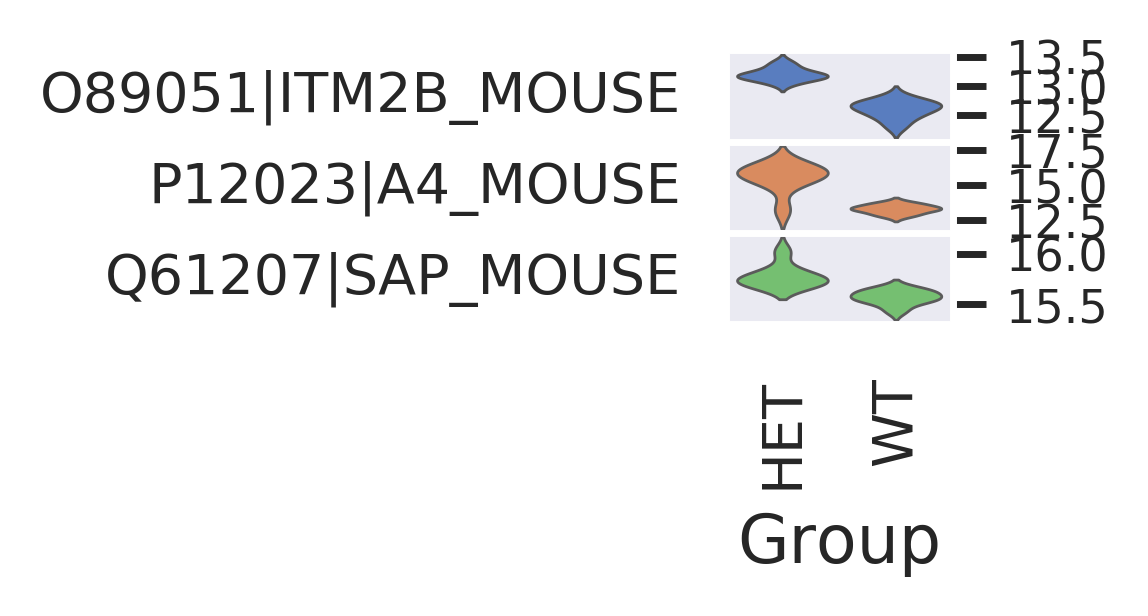

In [265]:
sc.pl.stacked_violin(cell_type_adata, groupby='Group', var_names=top_genes[:3], swap_axes=True)

## The Plot thickens

In [227]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)

         Falling back to preprocessing with `sc.pp.pca` and default params.


/home/kojo/miniconda3/envs/please/lib/python3.7/site-packages/scanpy/neighbors/__init__.py:87: DeprecationWarning: Use is_view instead of isview, isview will be removed in the future.
  if adata.isview:  # we shouldn't need this here...


ValueError: n_components=50 must be between 0 and min(n_samples, n_features)=48 with svd_solver='full'

## Viewing Results

In [44]:
import os
import scanpy as sc

home = '/home/kojo/Code/trVAE_reproducibility-2'
os.chdir(home)

In [45]:
import scanpy as sc
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
from scipy import sparse
from scipy import stats
from matplotlib import pyplot as plt
import reptrvae

In [46]:
sc.set_figure_params(dpi=200)

In [47]:
path_to_save = "./results/alzPro/"
sc.settings.figdir = path_to_save

In [48]:
specific_cell_type = "3m"

In [49]:
cell_type_key = "Timepoint"
condition_key = "Group"
target_condition = "HET"
conditions = ['WT', 'HET']

In [50]:
adata = sc.read("./data/alzPro_normalized.h5ad")
adata

AnnData object with n_obs × n_vars = 48 × 1729
    obs: 'Qi ID', 'sex', 'Group', 'Timepoint', 'n_counts'
    var: 'index'

In [51]:
adata = adata[adata.obs[condition_key].isin(conditions)]

In [52]:
cell_type_adata = adata[adata.obs[cell_type_key] == specific_cell_type]
cell_type_adata

View of AnnData object with n_obs × n_vars = 16 × 1729
    obs: 'Qi ID', 'sex', 'Group', 'Timepoint', 'n_counts'
    var: 'index'

In [53]:
ctrl_adata = cell_type_adata[cell_type_adata.obs[condition_key] == 'WT']
real_adata = cell_type_adata[cell_type_adata.obs[condition_key] == target_condition]

In [54]:
ctrl_adata.obs['method'] = 'WT'
real_adata.obs['method'] = target_condition

/home/kojo/miniconda3/envs/please/lib/python3.7/site-packages/ipykernel_launcher.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  """Entry point for launching an IPython kernel.
/home/kojo/miniconda3/envs/please/lib/python3.7/site-packages/ipykernel_launcher.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  


In [55]:
trvae_reconstructed = sc.read(f"./data/reconstructed/trVAE_alzPro/{specific_cell_type}.h5ad")
trvae_reconstructed

AnnData object with n_obs × n_vars = 16 × 1729
    obs: 'Qi ID', 'sex', 'Group', 'Timepoint', 'n_counts', 'batch'
    var: 'index-1'

In [56]:
trvae_pred = trvae_reconstructed[trvae_reconstructed.obs[condition_key] == f"WT_to_{target_condition}"]
trvae_pred.var = ctrl_adata.var
trvae_pred.obs['method'] = 'trVAE'

In [57]:
models = ctrl_adata.concatenate(real_adata, trvae_pred)
models.obs['method'].unique()

/home/kojo/miniconda3/envs/please/lib/python3.7/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


array(['WT', 'HET', 'trVAE'], dtype=object)

In [58]:
models.var_names

Index(['Q7TME0|PLPR4_MOUSE', 'Q60749|KHDR1_MOUSE', 'Q80ZJ1|RAP2A_MOUSE',
       'Q8CDG3|VCIP1_MOUSE', 'Q03137|EPHA4_MOUSE', 'Q9R0H0|ACOX1_MOUSE',
       'Q8C163|EXOG_MOUSE', 'P18572|BASI_MOUSE', 'Q920E5|FPPS_MOUSE',
       'P04104|K2C1_MOUSE',
       ...
       'P45376|ALDR_MOUSE', 'P56812|PDCD5_MOUSE', 'Q9JKW0|AR6P1_MOUSE',
       'Q8JZQ9|EIF3B_MOUSE', 'Q61696|HS71A_MOUSE', 'Q00612|G6PD1_MOUSE',
       'Q9JK42|PDK2_MOUSE', 'P07309|TTHY_MOUSE', 'Q9DBL1|ACDSB_MOUSE',
       'P97355|SPSY_MOUSE'],
      dtype='object', name='index', length=1729)

saving figure to file ./results/alzPro/violin_model_cmpr.pdf


/home/kojo/miniconda3/envs/please/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/kojo/miniconda3/envs/please/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


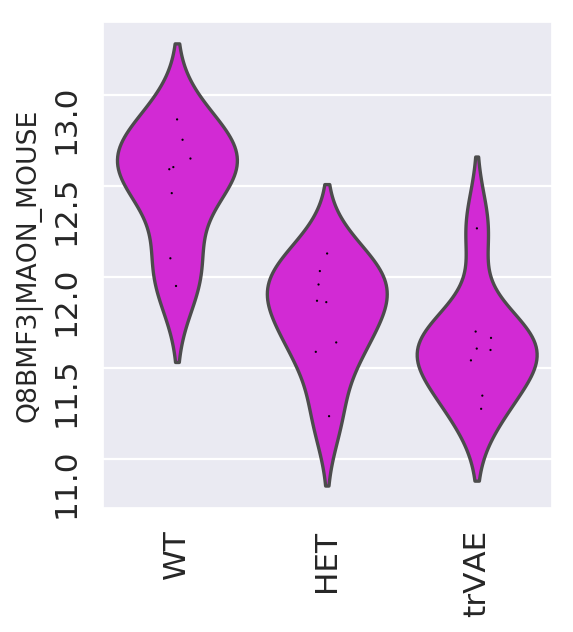

In [81]:
font = {'family' : 'Arial',
        'size'   : 30}

sc.set_figure_params(fontsize=25)
sns.set()
matplotlib.rc('ytick', labelsize=14)
matplotlib.rc('xtick', labelsize=14)
sc.pl.violin(models, 
             keys="Q8BMF3|MAON_MOUSE", 
             groupby="method", 
             rotation=90,
             show=True,
             order=models.obs["method"].unique().tolist(),
             color = "#ee0ef0",
             save="_model_cmpr.pdf",
             jitter=True,
            )
os.rename(src=os.path.join(path_to_save, "violin_model_cmpr.pdf"), 
          dst=os.path.join(path_to_save, "violin_model_comparison.pdf"))

### R^2 Plots

In [61]:
adata_pred = ctrl_adata.concatenate(real_adata, trvae_pred)
adata_pred

/home/kojo/miniconda3/envs/please/lib/python3.7/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


AnnData object with n_obs × n_vars = 24 × 1729
    obs: 'Qi ID', 'sex', 'Group', 'Timepoint', 'n_counts', 'method', 'batch'
    var: 'index'

In [62]:
sc.tl.rank_genes_groups(cell_type_adata, reference='WT', 
                       groupby=condition_key, groups=[target_condition],
                       key_added='up_reg_genes', n_genes=50)
sc.tl.rank_genes_groups(cell_type_adata, reference=target_condition,
                         groupby=condition_key, groups=['WT'],
                         key_added='down_reg_genes', n_genes=50)
up_genes = cell_type_adata.uns['up_reg_genes']['names'][target_condition]
down_genes = cell_type_adata.uns['down_reg_genes']['names']['WT']

/home/kojo/miniconda3/envs/please/lib/python3.7/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


In [88]:
top_genes = up_genes.tolist() + down_genes.tolist()

In [64]:
len(top_genes)

100

reg_mean_top100: 0.6769841876057726
reg_mean_all: 0.7279955963921818


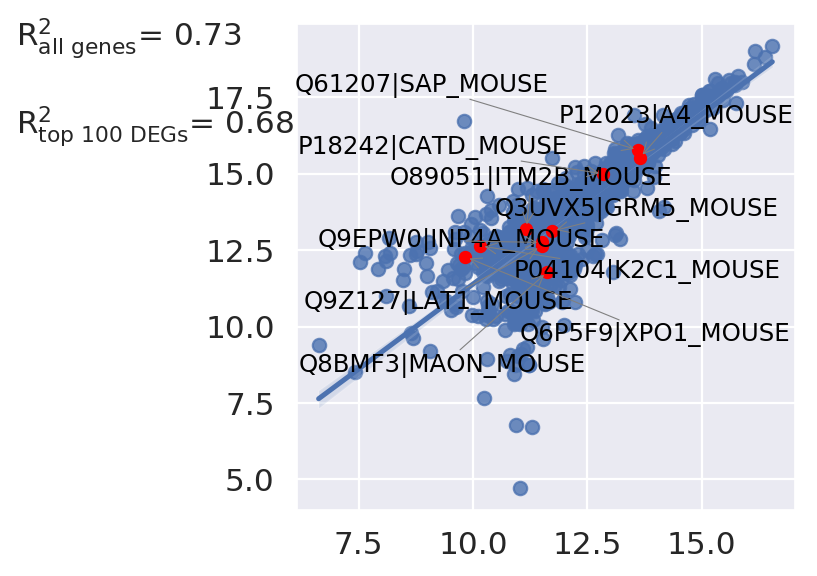

In [89]:
reptrvae.pl.reg_mean_plot(adata_pred,
                         top_100_genes=top_genes,
                         gene_list=top_genes[:5] + top_genes[50:55],
                         condition_key=condition_key,
                         axis_keys={'x': f"WT_to_{target_condition}", 'y': target_condition},
                         labels={'x': "", 'y': ""},
                         path_to_save=os.path.join(path_to_save, f"trVAE_{specific_cell_type}_reg_mean.pdf"),
                         legend=False,
                         show=True,
                         x_coeff=1.0,
                         y_coeff=0.0)

reg_var_top100: 0.0030689562906173386
reg_var_all: 0.012168535819820532


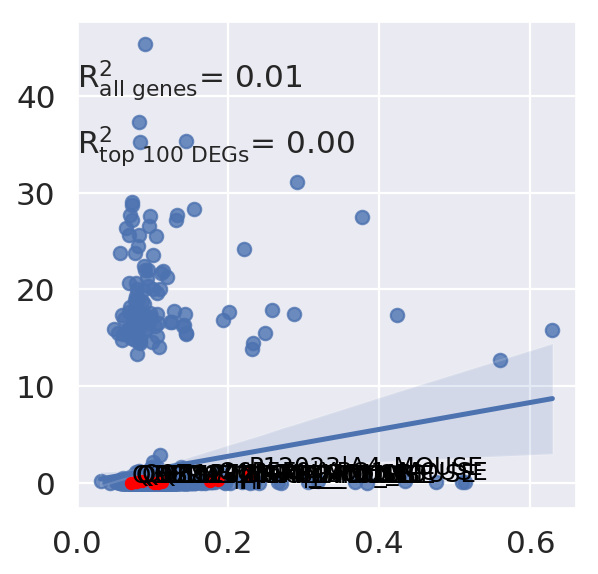

In [90]:
reptrvae.pl.reg_var_plot(adata_pred,
                         top_100_genes=top_genes,
                         gene_list=top_genes[:5] + top_genes[50:55],
                         condition_key=condition_key,
                         axis_keys={'x': f"WT_to_{target_condition}", 'y': target_condition},
                         labels={'x': "", 'y': ""},
                         path_to_save=os.path.join(path_to_save, f"trVAE_{specific_cell_type}_reg_var.pdf"),
                         legend=False,
                         show=True,
                         x_coeff=1.0,
                         y_coeff=0.1)

In [73]:
up_genes.tolist()

['O89051|ITM2B_MOUSE',
 'P12023|A4_MOUSE',
 'Q9EPW0|INP4A_MOUSE',
 'Q61207|SAP_MOUSE',
 'P18242|CATD_MOUSE',
 'Q9CQ89|CUTA_MOUSE',
 'P08226|APOE_MOUSE',
 'O88531|PPT1_MOUSE',
 'P47708|RP3A_MOUSE',
 'P30416|FKBP4_MOUSE',
 'Q9Z0X1|AIFM1_MOUSE',
 'Q9CQ22|LTOR1_MOUSE',
 'P10605|CATB_MOUSE',
 'Q8BZ98|DYN3_MOUSE',
 'A2AGT5|CKAP5_MOUSE',
 'P47857|PFKAM_MOUSE',
 'Q920E5|FPPS_MOUSE',
 'P55264|ADK_MOUSE',
 'P10518|HEM2_MOUSE',
 'Q9CPQ8|ATP5L_MOUSE',
 'Q91VD9|NDUS1_MOUSE',
 'P17751|TPIS_MOUSE',
 'P42669|PURA_MOUSE',
 'P57776|EF1D_MOUSE',
 'P70663|SPRL1_MOUSE',
 'Q99N28|CADM3_MOUSE',
 'P20152|VIME_MOUSE',
 'Q6PIE5|AT1A2_MOUSE',
 'Q61171|PRDX2_MOUSE',
 'Q3UGR5|HDHD2_MOUSE',
 'O88428|PAPS2_MOUSE',
 'Q8C0M9|ASGL1_MOUSE',
 'P16388|KCNA1_MOUSE',
 'P10649|GSTM1_MOUSE',
 'O35381|AN32A_MOUSE',
 'P56135|ATPK_MOUSE',
 'P60122|RUVB1_MOUSE',
 'Q6PA06|ATLA2_MOUSE',
 'P57722|PCBP3_MOUSE',
 'Q04447|KCRB_MOUSE',
 'Q9DBG6|RPN2_MOUSE',
 'P02802|MT1_MOUSE',
 'P61979|HNRPK_MOUSE',
 'Q80UP3|DGKZ_MOUSE',
 'Q08331|CALB2

In [74]:
down_genes.tolist()

['Q8BMF3|MAON_MOUSE',
 'P04104|K2C1_MOUSE',
 'Q3UVX5|GRM5_MOUSE',
 'Q9Z127|LAT1_MOUSE',
 'Q6P5F9|XPO1_MOUSE',
 'Q9EQF6|DPYL5_MOUSE',
 'Q8VDQ8|SIR2_MOUSE',
 'Q9JMA1|UBP14_MOUSE',
 'P35803|GPM6B_MOUSE',
 'Q7M6Y3|PICAL_MOUSE',
 'P31938|MP2K1_MOUSE',
 'Q99LD4|CSN1_MOUSE',
 'Q80ZJ1|RAP2A_MOUSE',
 'O88544|CSN4_MOUSE',
 'Q62188|DPYL3_MOUSE',
 'P57780|ACTN4_MOUSE',
 'O55100|SNG1_MOUSE',
 'P12849|KAP1_MOUSE',
 'Q5PR73|DIRA2_MOUSE',
 'P62746|RHOB_MOUSE',
 'Q922Q4|P5CR2_MOUSE',
 'P14094|AT1B1_MOUSE',
 'Q922J6|TSN2_MOUSE',
 'P19096|FAS_MOUSE',
 'Q6ZPE2|MTMR5_MOUSE',
 'P23818|GRIA1_MOUSE',
 'Q62418|DBNL_MOUSE',
 'Q9DB15|RM12_MOUSE',
 'Q9DBG3|AP2B1_MOUSE',
 'P61205|ARF3_MOUSE',
 'P07309|TTHY_MOUSE',
 'P32037|GTR3_MOUSE',
 'P20444|KPCA_MOUSE',
 'P62482|KCAB2_MOUSE',
 'Q80XI4|PI42B_MOUSE',
 'O08756|HCD2_MOUSE',
 'Q99JI6|RAP1B_MOUSE',
 'Q91YJ2|SNX4_MOUSE',
 'Q9Z2I2|FKB1B_MOUSE',
 'P16330|CN37_MOUSE',
 'Q9Z0H4|CELF2_MOUSE',
 'Q80YN3|BCAS1_MOUSE',
 'Q60996|2A5G_MOUSE',
 'O88737|BSN_MOUSE',
 'Q6PEB6|PHOCN